In [1]:
!pip install -q diffusers transformers accelerate scipy safetensors

In [2]:
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import requests
from io import BytesIO
from huggingface_hub import notebook_login

# Configuración del dispositivo (Usa GPU si está disponible)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Cargamos el pipeline pre-entrenado
# torch_dtype=torch.float16 hace que sea más rápido y use menos memoria
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", # Cambiado a un modelo de inpainting existente
    torch_dtype=torch.float16,
)
pipe = pipe.to(device)

print("¡Modelo cargado exitosamente en la GPU!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

safety_checker/pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
`torch_dtype` is deprecated! Use `dtype` instead!
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


¡Modelo cargado exitosamente en la GPU!


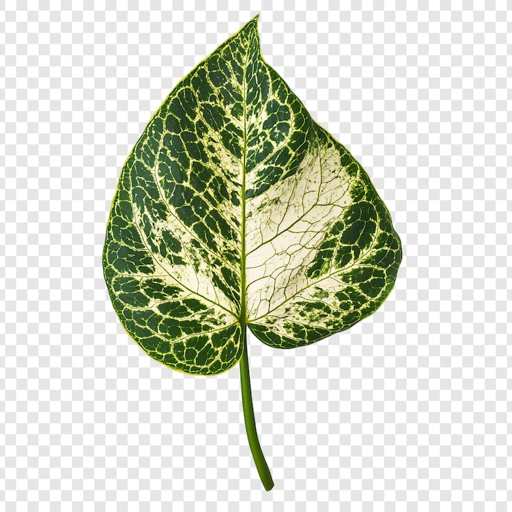

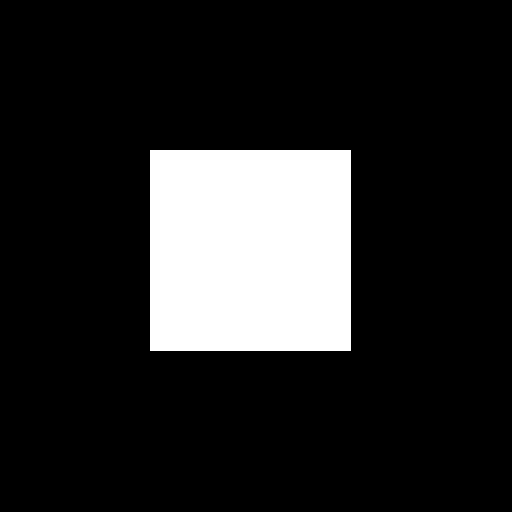

In [3]:
# 1. Descargar una imagen de una hoja
url = "https://img.freepik.com/psd-gratis/impresionante-primer-plano-hoja-filodendro-variada_632498-24802.jpg?semt=ais_hybrid&w=740&q=80" # Una URL confiable que apunta directamente a una imagen de hoja
response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB").resize((512, 512))

# 2. Crear la máscara (El problema de oclusión)
# Creamos una imagen negra y dibujamos un cuadro blanco donde queremos "borrar" la hoja
mask_image = Image.new("RGB", (512, 512), "black")
from PIL import ImageDraw
draw = ImageDraw.Draw(mask_image)

# Coordenadas del "parche" (x1, y1, x2, y2)
draw.rectangle((150, 150, 350, 350), fill="white")

# Mostrar las imágenes preparadas
display(init_image) # Hoja original
display(mask_image) # La máscara (lo blanco es lo que la IA va a re-pintar)

  0%|          | 0/50 [00:00<?, ?it/s]

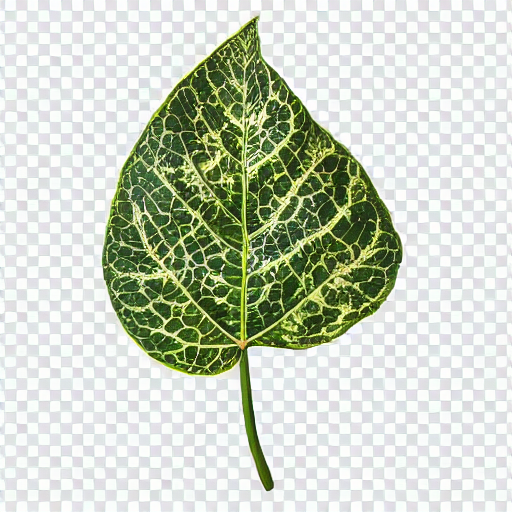

In [4]:
# El prompt es la instrucción para la IA
prompt = "high resolution, detailed green leaf texture, veins, macro photography, realistic"

# Generamos la imagen
# num_inference_steps=50 es un estándar de calidad
output = pipe(prompt=prompt, image=init_image, mask_image=mask_image, num_inference_steps=50).images[0]

# Guardamos el resultado
output.save("hoja_reconstruida.png")
display(output)

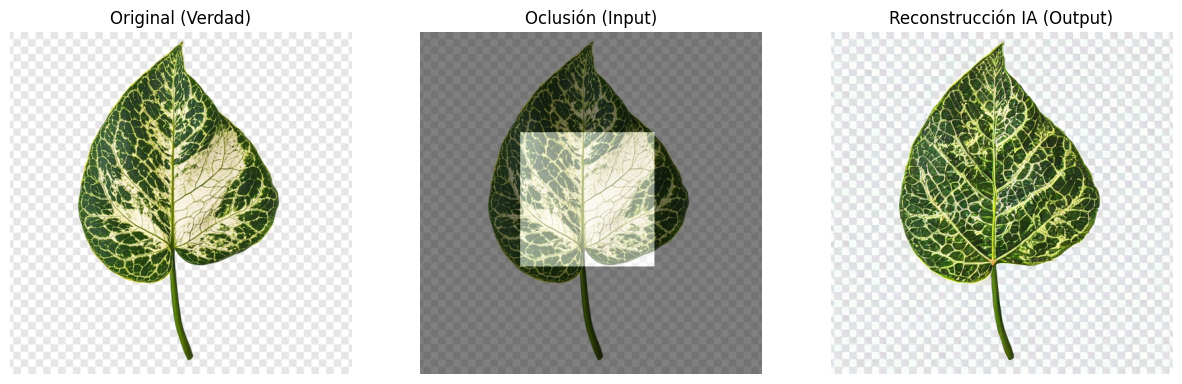

In [5]:
import matplotlib.pyplot as plt

def plot_comparison(original, mask, result):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(original)
    axs[0].set_title("Original (Verdad)")
    axs[0].axis("off")

    # Superponer máscara para visualizar la oclusión
    axs[1].imshow(original)
    axs[1].imshow(mask, alpha=0.5) # Máscara semitransparente
    axs[1].set_title("Oclusión (Input)")
    axs[1].axis("off")

    axs[2].imshow(result)
    axs[2].set_title("Reconstrucción IA (Output)")
    axs[2].axis("off")

    plt.show()

plot_comparison(init_image, mask_image, output)